# SETUP

In [1]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.9 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary
from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution

from tqdm import tqdm

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [9]:
data_dir = os.path.join('/content/drive/MyDrive/Colab Notebooks/U-Net/cityscapes_data/cityscapes_data')
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


# ANALYZE DATA

/content/drive/MyDrive/Colab Notebooks/U-Net/cityscapes_data/cityscapes_data/train/2788.jpg


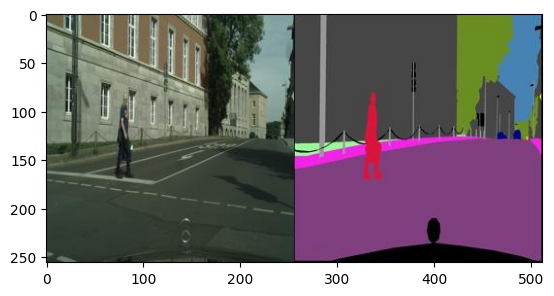

In [10]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [11]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(256, 512, 3)
0 255 0 255


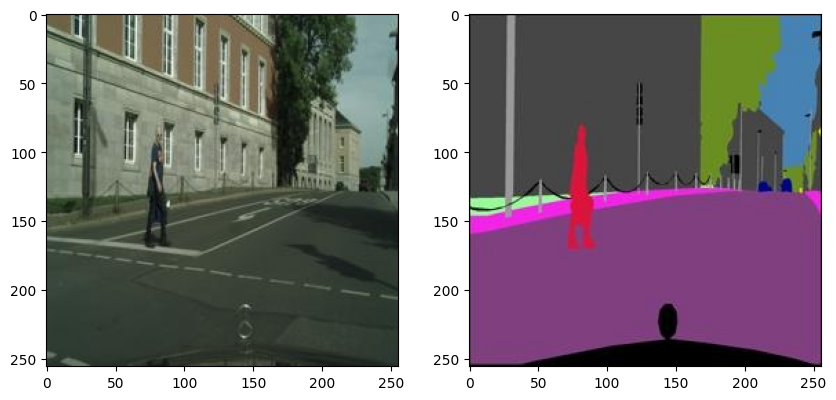

In [12]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

# LABELS

In [13]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 81  83 161]
 [ 81 184  87]
 [ 45 210  85]
 [ 27 205 228]
 [ 20 173 186]]


In [14]:
num_classes = 10
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10)

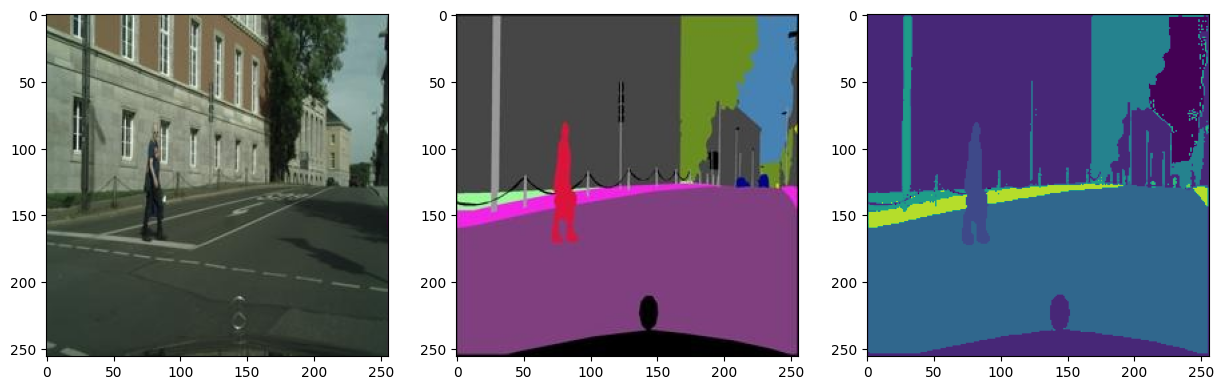

In [15]:
label_model.predict(color_array[:5, :])
cityscape, label = split_image(sample_image)
label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

# DATASET

In [16]:
class CityscapeDataset(Dataset):

    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        cityscape, label = self.split_image(image)
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
        cityscape = self.transform(cityscape)
        label_class = torch.Tensor(label_class).long()
        return cityscape, label_class

    def split_image(self, image):
        image = np.array(image)
        cityscape, label = image[:, :256, :], image[:, 256:, :]
        return cityscape, label

    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [50]:
dataset = CityscapeDataset(train_dir, label_model)
print(f'Dataset: {len(dataset)}')

cityscape, label_class = dataset[0]
print(f'Cityscape: {cityscape.shape}, Label: {label_class.shape}')

val_dataset = CityscapeDataset(val_dir, label_model)
print(f'Validation dataset: {len(val_dataset)}')

Dataset: 2975
Cityscape: torch.Size([3, 256, 256]), Label: torch.Size([256, 256])
Validation dataset: 500


# MODEL


In [18]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [19]:
model = UNet(num_classes=num_classes)

In [51]:
data_loader = DataLoader(dataset, batch_size=4)
val_loader = DataLoader(val_dataset, batch_size=4)
print(len(dataset), len(data_loader))

X, Y = next(iter(data_loader))
print(X.shape, Y.shape)

2975 744
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256])


In [21]:
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([4, 10, 256, 256])


# TRAIN

In [22]:
batch_size = 16

epochs = 40
lr = 0.01

In [23]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size=batch_size)

In [24]:
model = UNet(num_classes=num_classes).to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
step_losses = []
epoch_losses = []
for epoch in range(epochs):
    epoch_loss = 0
    train_accuracy=0.0
    train_loss=0.0
    for X, Y in tqdm(data_loader, total=len(data_loader), leave=False):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        step_losses.append(loss.item())
    epoch_losses.append(epoch_loss/len(data_loader))
    print("epoch:", epoch, "epoch loss: ", epoch_loss)
print("___________________________________________________________________")

epoch: 0 epoch loss:  93.9889320731163


epoch: 1 epoch loss:  68.40392249822617


epoch: 2 epoch loss:  66.39669841527939


epoch: 3 epoch loss:  61.660871624946594


epoch: 4 epoch loss:  57.10723114013672


epoch: 5 epoch loss:  54.95448273420334


epoch: 6 epoch loss:  54.50930517911911


epoch: 7 epoch loss:  52.506123185157776


epoch: 8 epoch loss:  51.480136811733246


epoch: 9 epoch loss:  50.87221312522888


epoch: 10 epoch loss:  50.268846571445465


epoch: 11 epoch loss:  49.95469921827316


epoch: 12 epoch loss:  49.84924191236496


epoch: 13 epoch loss:  48.30925530195236


epoch: 14 epoch loss:  47.838349640369415


epoch: 15 epoch loss:  48.81707066297531


epoch: 16 epoch loss:  46.99100995063782


epoch: 17 epoch loss:  46.16177922487259


epoch: 18 epoch loss:  45.298146426677704


epoch: 19 epoch loss:  44.85058236122131


epoch: 20 epoch loss:  43.92922979593277


epoch: 21 epoch loss:  44.30841210484505


epoch: 22 epoch loss:  43.015072375535965


epoch: 23 epoch loss:  42.649471789598465


epoch: 24 epoch loss:  41.372136026620865


epoch: 25 epoch loss:  40.587201565504074


epoch: 26 epoch loss:  39.789866387844086


epoch: 27 epoch loss:  39.20894834399223


epoch: 28 epoch loss:  38.64569368958473


epoch: 29 epoch loss:  37.91548764705658


epoch: 30 epoch loss:  37.10993120074272


epoch: 31 epoch loss:  35.90190401673317


epoch: 32 epoch loss:  35.16216292977333


epoch: 33 epoch loss:  35.825181782245636


epoch: 34 epoch loss:  34.71804878115654


epoch: 35 epoch loss:  33.2595648765564


epoch: 36 epoch loss:  32.61983534693718


epoch: 37 epoch loss:  31.867176443338394


epoch: 38 epoch loss:  33.073388040065765


epoch: 39 epoch loss:  31.353128910064697
___________________________________________________________________


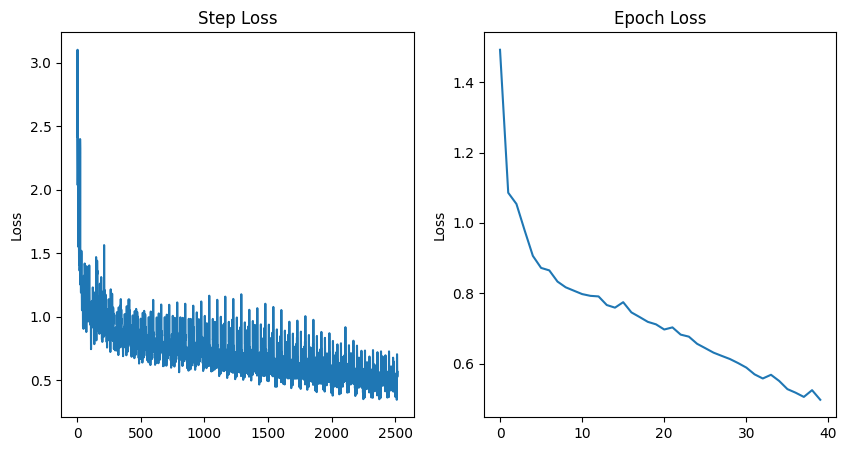

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].set_ylabel('Loss')
axes[0].set_title('Step Loss')
axes[0].plot(step_losses)

axes[1].set_ylabel('Loss')
axes[1].set_title('Epoch Loss')
axes[1].plot(epoch_losses)

plt.show()


In [32]:
model_name = "U-Net-ood-40Epoch.pth"
torch.save(model.state_dict(), model_name)

# Validation tests

In [52]:
from sklearn.metrics import jaccard_score

def calculate_iou(y_true, y_pred):
    y_true = y_true.view(-1).cpu().numpy()
    y_pred = y_pred.view(-1).cpu().numpy()
    return jaccard_score(y_true, y_pred, average='macro')

model.eval()

val_losses = []
val_ious = []

with torch.no_grad():
    for X_val, Y_val in tqdm(val_loader, total=len(val_loader), leave=False):
        X_val, Y_val = X_val.to(device), Y_val.to(device)

        Y_val_pred = model(X_val)

        val_loss = criterion(Y_val_pred, Y_val)

        _, Y_val_pred = torch.max(Y_val_pred, 1)

        val_iou_batch = calculate_iou(Y_val, Y_val_pred)
        val_ious.append(val_iou_batch.item())

        val_losses.append(val_loss.item())

mean_val_iou = np.mean(val_ious)
mean_val_loss = np.mean(val_losses)

print(f"Validation Loss: {mean_val_loss:.4f}, Mean IoU: {mean_val_iou * 100:.2f}%")

Validation Loss: 1.0639, Mean IoU: 29.44%


# PREDICTIONS

In [56]:
model_path = "/content/U-Net-ood-40Epoch.pth"
model_ = UNet(num_classes=num_classes).to(device)
model_.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [57]:
test_batch_size = 8
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size=test_batch_size)

X, Y = next(iter(data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)
print(Y_pred.shape)
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

torch.Size([8, 10, 256, 256])
torch.Size([8, 256, 256])


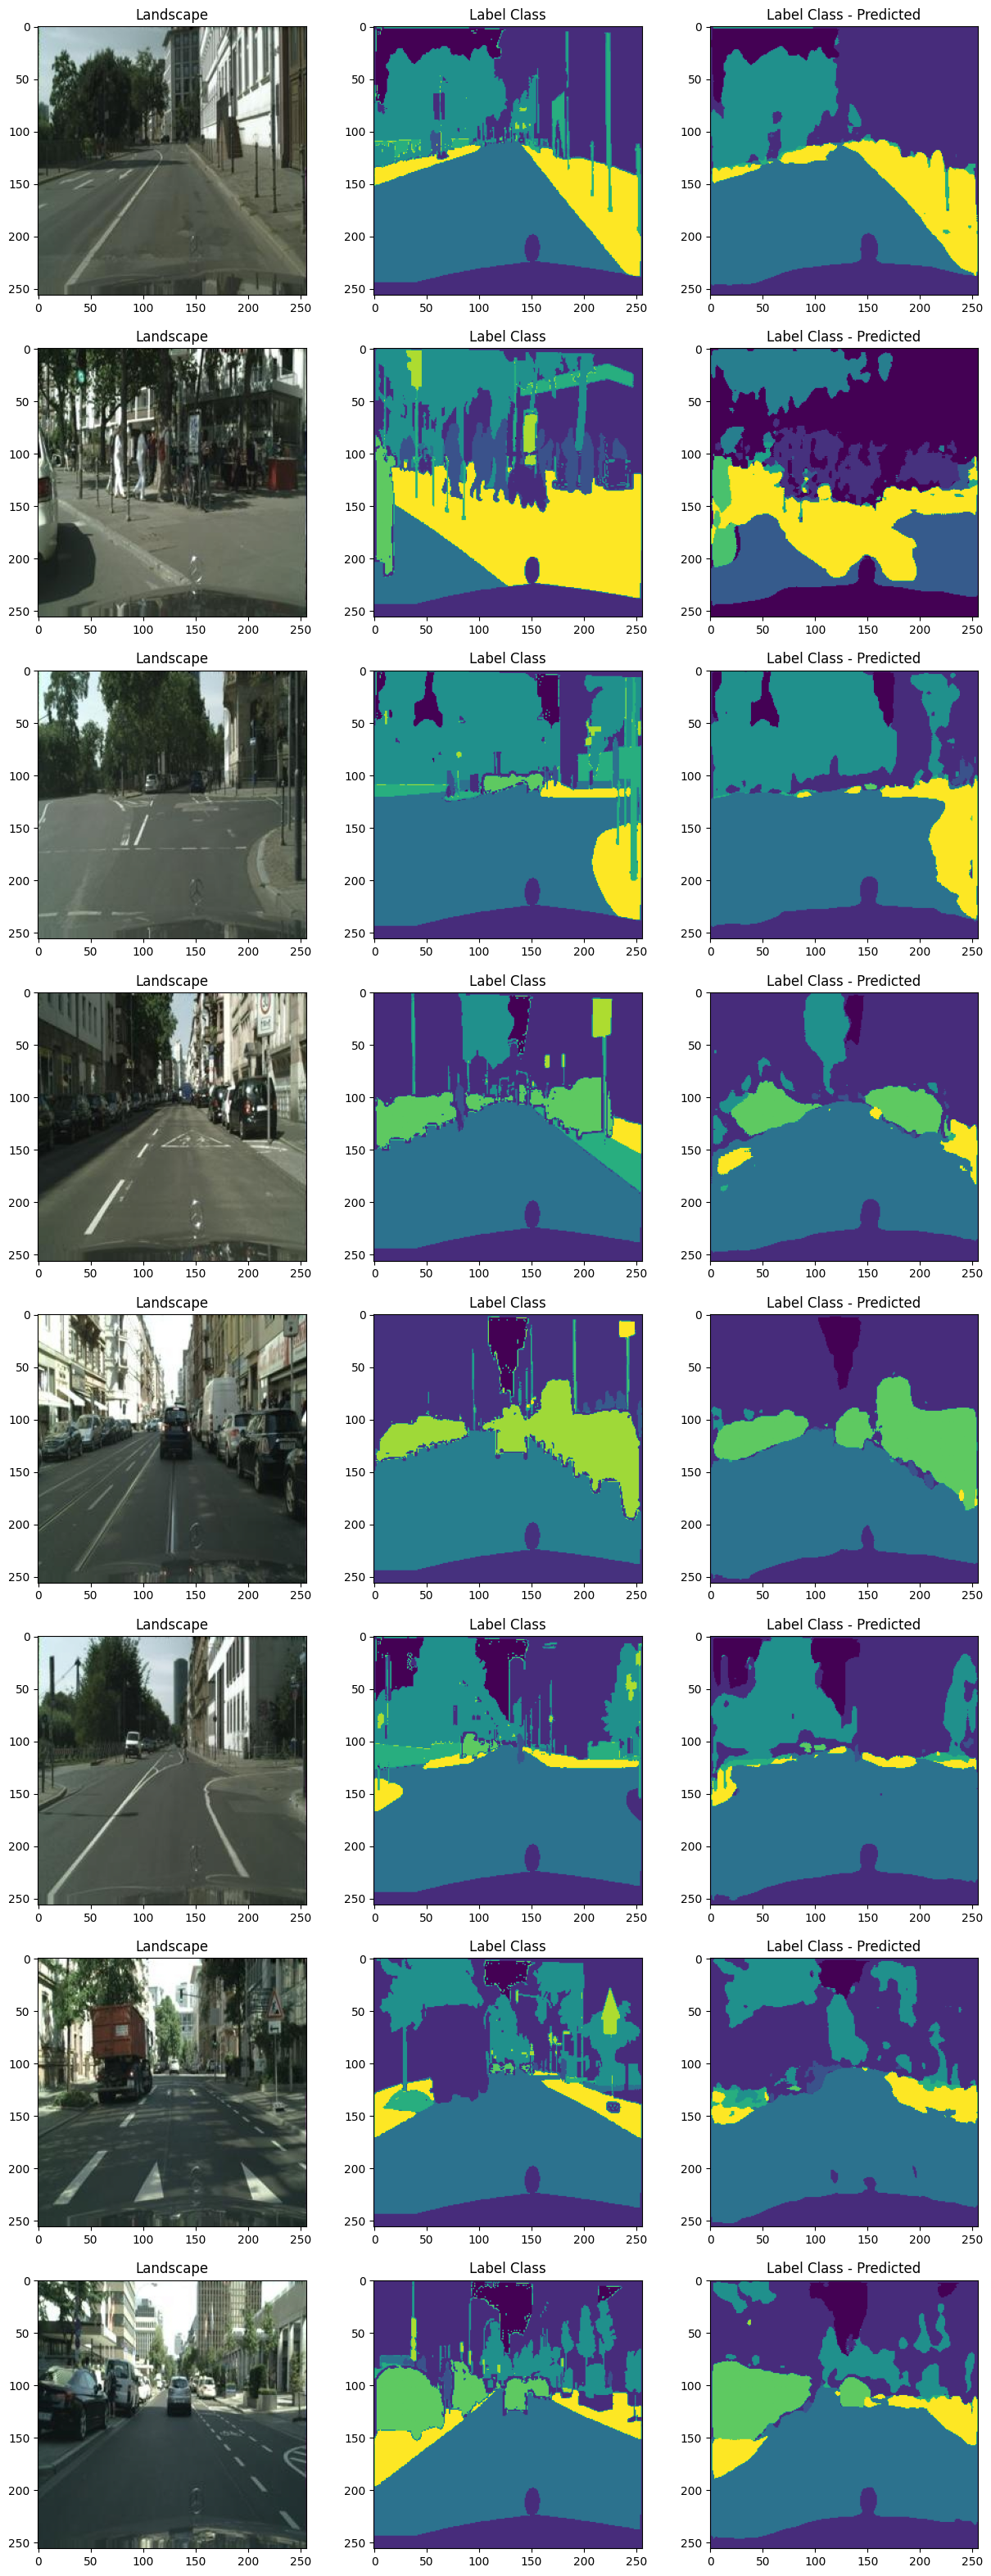

In [58]:
fig, axes = plt.subplots(test_batch_size, 3, figsize=(3*5, test_batch_size*5))

for i in range(test_batch_size):

    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()

    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")